In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distrib

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline  
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


### Example of a simple 3d plot

In [192]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # Make data.
# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)

# # Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()

### Distribution params

In [256]:
mu0x = 1.0
mu0y = 1.0
sigma0x = 0.5
sigma0y = 0.5
mu0 = [mu0x, mu0y]
sigma0 = [sigma0x, sigma0y]

mu1x = 2.0
mu1y = 4.0
sigma1x = 2.0
sigma1y = 1.0
mu1 = [mu1x, mu1y]
sigma1 = [sigma1x, sigma1y]

### Plot distributions

In [257]:
def plot_distribution(mu, sigma, pos):
    rv = stats.multivariate_normal(mu, sigma)
    return rv.pdf(pos)
    
def plot_two_distributions(mu0, sigma0, mu1, sigma1):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    X = np.arange(-3, 7, 0.25)
    Y = np.arange(-3, 7, 0.25)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    
    Z = plot_distribution(mu0, sigma0, pos)
    Z = Z + plot_distribution(mu1, sigma1, pos)
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    # Customize the z axis.
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.01f}')
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()

<IPython.core.display.Javascript object>


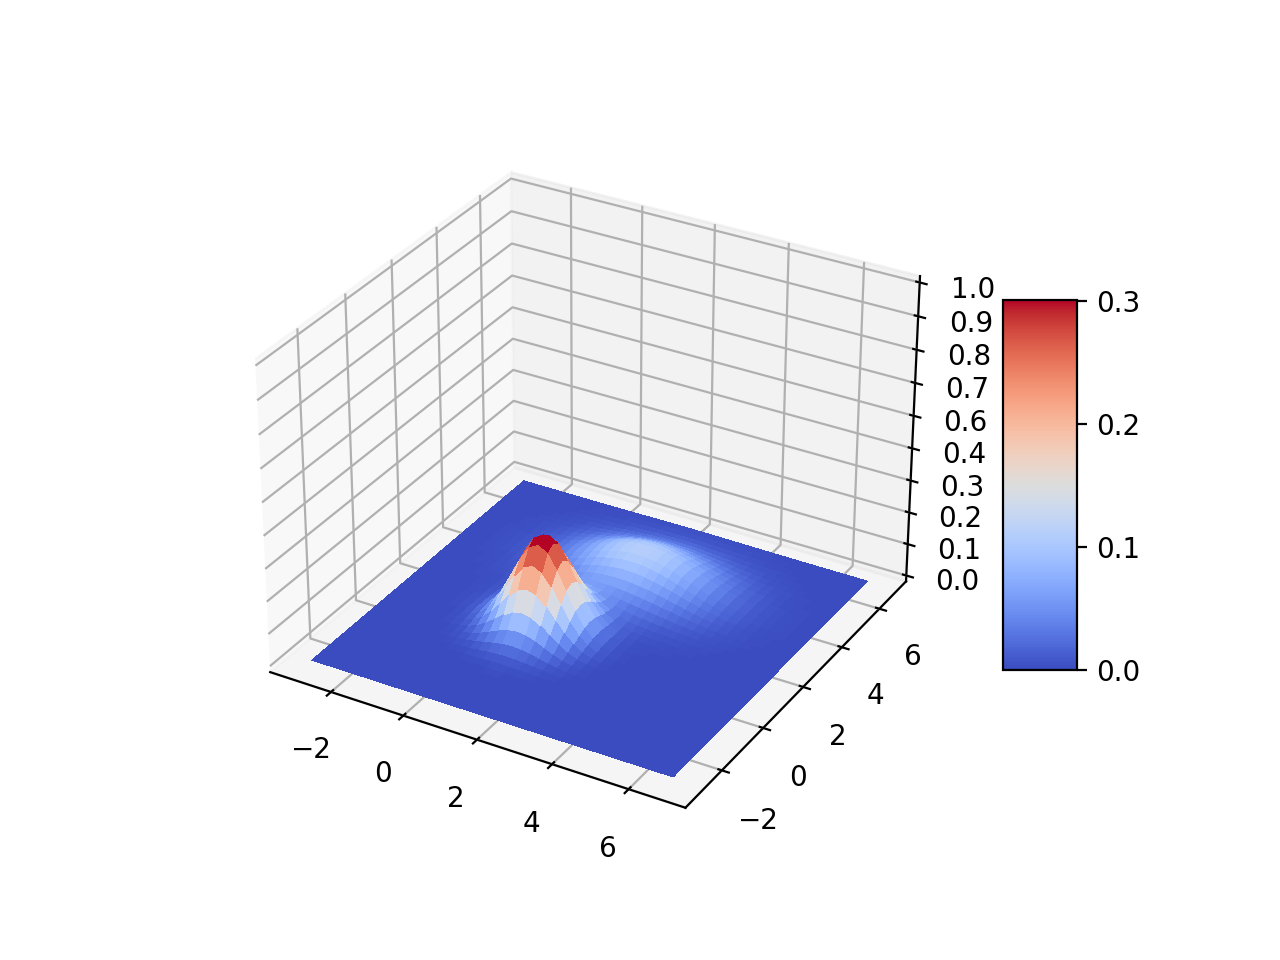

In [258]:
plot_two_distributions(mu0, sigma0, mu1, sigma1)

### Torch distribution & sampling fun

In [259]:
d0 = distrib.Normal(torch.tensor(mu0), torch.tensor(sigma0))
d1 = distrib.Normal(torch.tensor(mu1), torch.tensor(sigma1))

In [296]:
def sample(d0, d1, n):
    x0 = d0.sample((n,))
    y0 = torch.zeros((x0.shape[0], 1))
    
    x1 = d1.sample((n,))
    y1 = torch.ones((x1.shape[0], 1))
    
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

### NN structure & training fun

In [321]:
layer = nn.Linear(2, 1)
print('Parameter values on initialisation:', [p.data[0] for p in layer.parameters()])

Parameter values on initialisation: [tensor([ 0.0866, -0.3918]), tensor(-0.5423)]


In [330]:
def get_params(layer):
    return [p.data[0] for p in layer.parameters()]

def train(learning_rate, iterations, update_each_iter):
    layer = nn.Linear(2, 1)
    print('Parameter values on initialisation:', [p.data[0] for p in layer.parameters()])
    
    optimizer = optim.SGD(lr=learning_rate, params=list(layer.parameters()))
    
    for i in range(iterations):
        # print model performance each 'update_each_iter' iterations
        if i % update_each_iter == 0:
            # this operation should not involve calculation of gradients (saves memory)
            with torch.no_grad():
                # take a bigger sample, calculate predictions and loss
                x, y = sample(d0, d1, 10000)
                predictions = torch.sigmoid(layer(x))
                loss = F.binary_cross_entropy(predictions, y)
                print(f'Error after {i: 5} iteration: {loss:.3f}')
        
        # reset previous gradients
        optimizer.zero_grad()
        # generate new training batch
        x, y = sample(d0, d1, 1024)
        # calculate preditions
        predictions = torch.sigmoid(layer(x))
        # calculate loss
        loss = F.binary_cross_entropy(predictions, y)
        # calculate gradients
        loss.backward()
        # subtract gradients from current minimum
        optimizer.step()
        
    return layer

In [328]:
layer = train(0.001, 100_000, 10000)
print(f'params after training: {get_params(layer)}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Parameter values on initialisation: [tensor([ 0.3711, -0.0189]), tensor(0.3894)]
Error after     0 iteration: 0.743
Error after  10000 iteration: 0.346
Error after  20000 iteration: 0.245
Error after  30000 iteration: 0.194
Error after  40000 iteration: 0.164
Error after  50000 iteration: 0.149
Error after  60000 iteration: 0.134
Error after  70000 iteration: 0.123
Error after  80000 iteration: 0.117
Error after  90000 iteration: 0.110
params: <generator object Module.parameters at 0x7ff93a85d8d0>


In [334]:
layer = train(0.01, 10_000, 1000)
print(f'params after training: {get_params(layer)}')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.25 µs
Parameter values on initialisation: [tensor([-0.2352, -0.6362]), tensor(0.5210)]
Error after     0 iteration: 1.572
Error after  1000 iteration: 0.371
Error after  2000 iteration: 0.255
Error after  3000 iteration: 0.199
Error after  4000 iteration: 0.168
Error after  5000 iteration: 0.149
Error after  6000 iteration: 0.136
Error after  7000 iteration: 0.125
Error after  8000 iteration: 0.117
Error after  9000 iteration: 0.112


params after training: [tensor([0.1255, 2.2534]), tensor(-4.9499)]


In [336]:
layer = train(0.1, 1000, 100)
print(f'params after training: {get_params(layer)}')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
Parameter values on initialisation: [tensor([-0.5593,  0.5175]), tensor(-0.3119)]
Error after     0 iteration: 0.562
Error after   100 iteration: 0.298
Error after   200 iteration: 0.223
Error after   300 iteration: 0.184
Error after   400 iteration: 0.161
Error after   500 iteration: 0.141
Error after   600 iteration: 0.128
Error after   700 iteration: 0.121
Error after   800 iteration: 0.116
Error after   900 iteration: 0.106


In [338]:
layer = train(0.2, 1000, 100)
print(f'params after training: {get_params(layer)}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Parameter values on initialisation: [tensor([-0.2119, -0.3047]), tensor(-0.0251)]
Error after     0 iteration: 1.163
Error after   100 iteration: 0.234
Error after   200 iteration: 0.162
Error after   300 iteration: 0.130
Error after   400 iteration: 0.115
Error after   500 iteration: 0.106
Error after   600 iteration: 0.099
Error after   700 iteration: 0.091
Error after   800 iteration: 0.086
Error after   900 iteration: 0.085


In [340]:
layer = train(0.4, 1000, 100)
print(f'params after training: {get_params(layer)}')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs
Parameter values on initialisation: [tensor([0.1308, 0.6064]), tensor(0.6877)]
Error after     0 iteration: 0.842
Error after   100 iteration: 0.164
Error after   200 iteration: 0.120
Error after   300 iteration: 0.100
Error after   400 iteration: 0.090
Error after   500 iteration: 0.083
Error after   600 iteration: 0.079
Error after   700 iteration: 0.073
Error after   800 iteration: 0.067
Error after   900 iteration: 0.074


In [342]:
layer = train(0.8, 1000, 100)
print(f'params after training: {get_params(layer)}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Parameter values on initialisation: [tensor([-0.4707,  0.1008]), tensor(-0.5035)]
Error after     0 iteration: 0.895
Error after   100 iteration: 0.114
Error after   200 iteration: 0.088
Error after   300 iteration: 0.078
Error after   400 iteration: 0.073
Error after   500 iteration: 0.069
Error after   600 iteration: 0.068
Error after   700 iteration: 0.067
Error after   800 iteration: 0.062
Error after   900 iteration: 0.062


In [347]:
layer = train(1, 1000, 100)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([-0.5139,  0.1826]), tensor(-0.5828)]
Error after     0 iteration: 0.844
Error after   100 iteration: 0.104
Error after   200 iteration: 0.083
Error after   300 iteration: 0.074
Error after   400 iteration: 0.070
Error after   500 iteration: 0.068
Error after   600 iteration: 0.066
Error after   700 iteration: 0.061
Error after   800 iteration: 0.066
Error after   900 iteration: 0.059
params after training: [tensor([0.4462, 4.3655]), tensor(-9.7232)]


In [348]:
layer = train(1.5, 1000, 100)
print(f'params after training: {get_params(layer)}')

Parameter values on initialisation: [tensor([0.0742, 0.6232]), tensor(0.1157)]
Error after     0 iteration: 0.633
Error after   100 iteration: 0.090
Error after   200 iteration: 0.074
Error after   300 iteration: 0.064
Error after   400 iteration: 0.062
Error after   500 iteration: 0.059
Error after   600 iteration: 0.060
Error after   700 iteration: 0.065
Error after   800 iteration: 0.062
Error after   900 iteration: 0.063
params after training: [tensor([0.4982, 4.6932]), tensor(-10.5100)]


### Plot decision surface

In [445]:
def plot_decision_surface(layer):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    X = np.arange(-3, 7, 0.25, dtype=np.double)
    Y = np.arange(-3, 7, 0.25, dtype=np.double)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    
    with torch.no_grad():
        Z = torch.sigmoid(layer(torch.from_numpy(pos).float())).detach().numpy()
    
    # Plot the surface.
    Z = Z.reshape(X.shape)
    
    print(Z.shape, X.shape)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    # Customize the z axis.
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.01f}')
    
#     fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()
    
    return Z

<IPython.core.display.Javascript object>


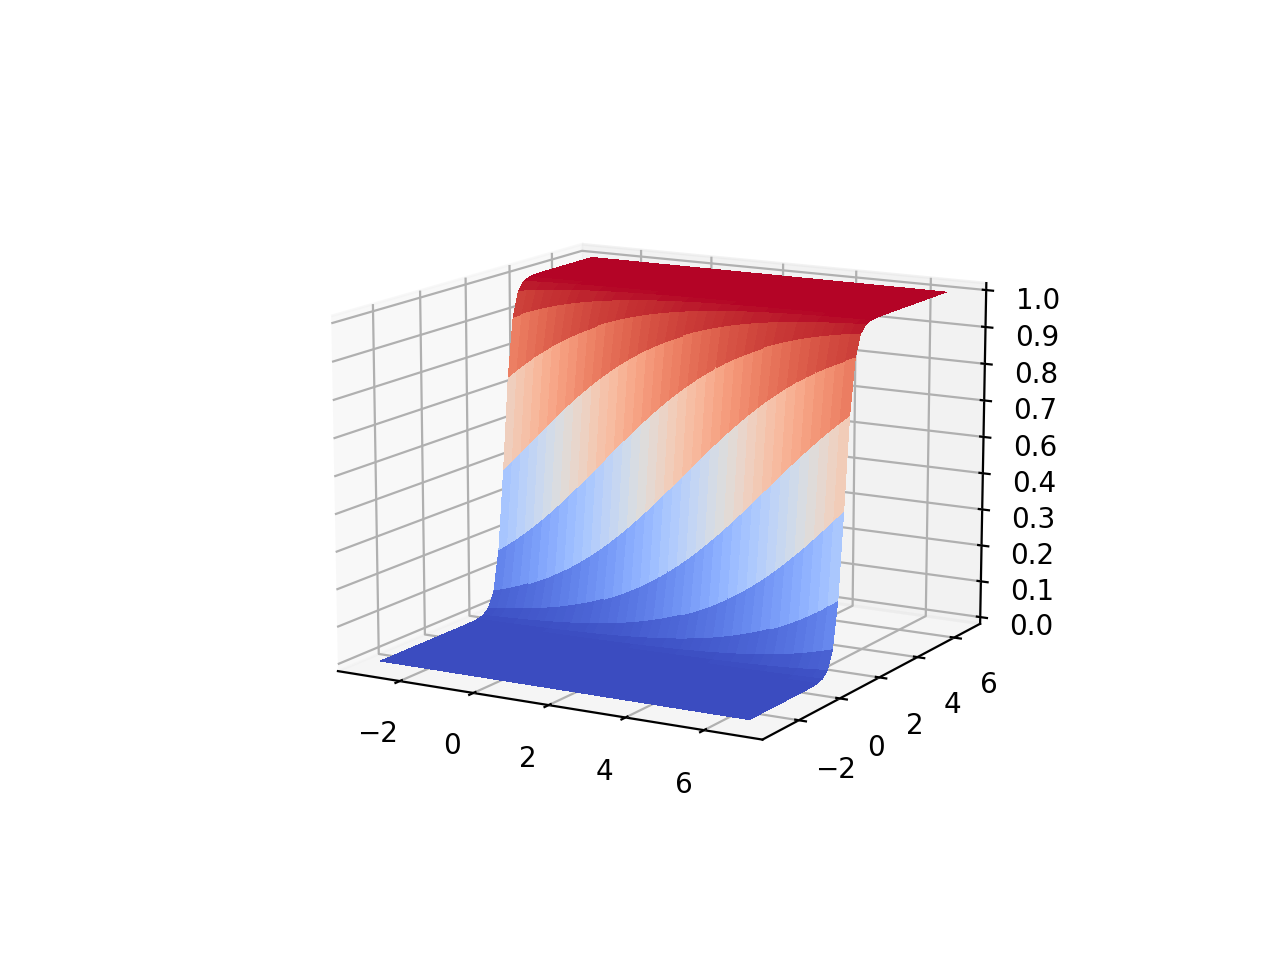

(40, 40) (40, 40)


In [446]:
Z = plot_decision_surface(layer)